In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
def show_image(image):
    if image.shape[-1] == 1:
        #grayscale
        display(Image.fromarray(image))
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(image_rgb))

In [4]:
video = cv2.VideoCapture('video.mp4')

In [51]:
for i in range(200):
    ret, frame = video.read()

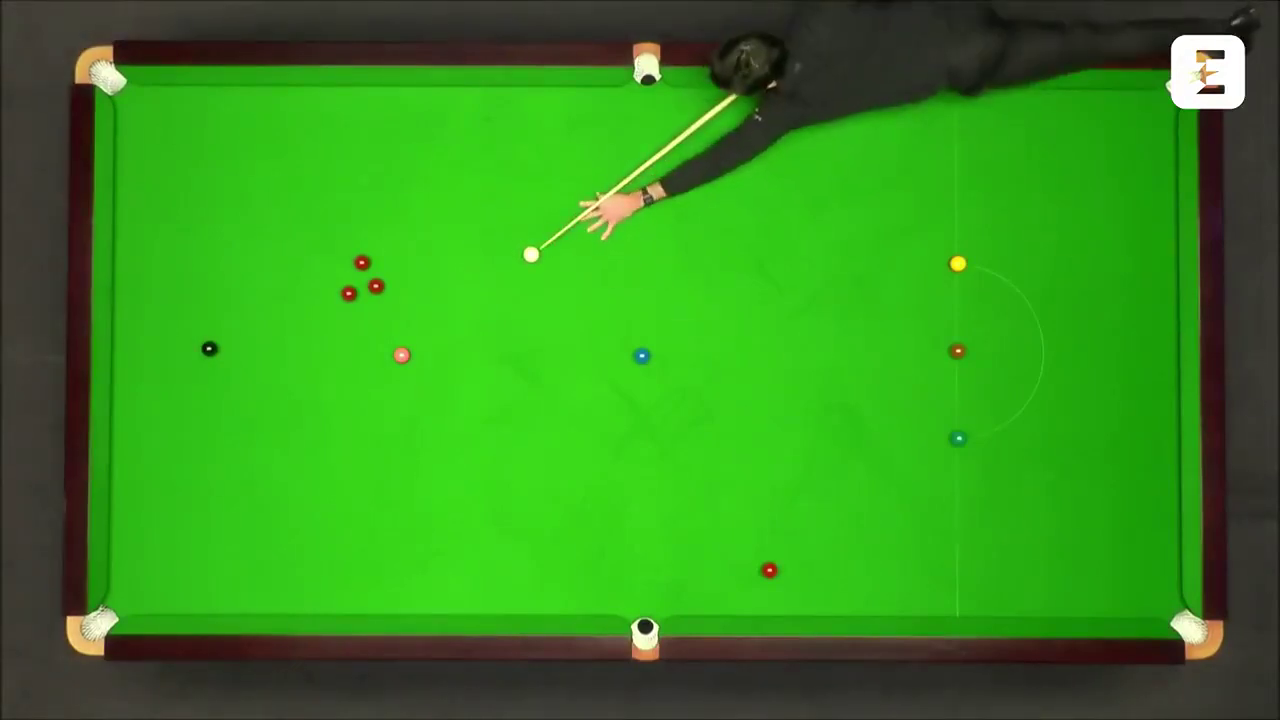

In [52]:
show_image(frame)

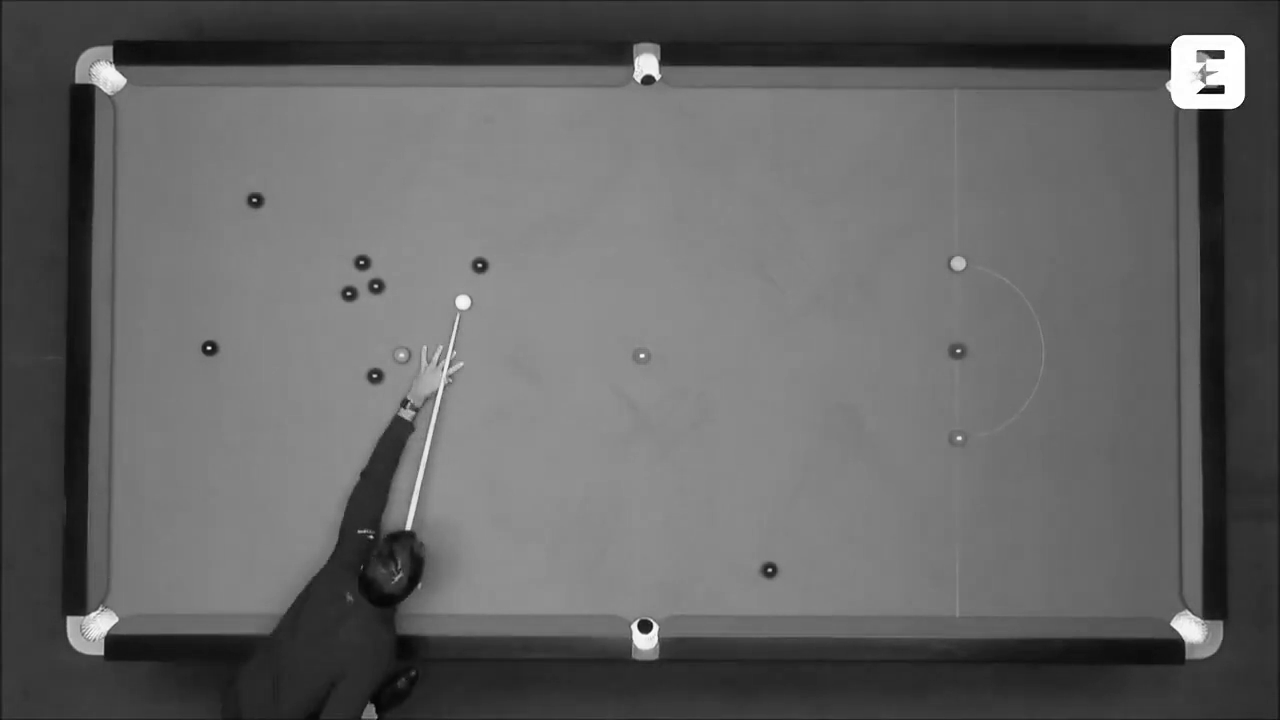

In [44]:
show_image(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY))

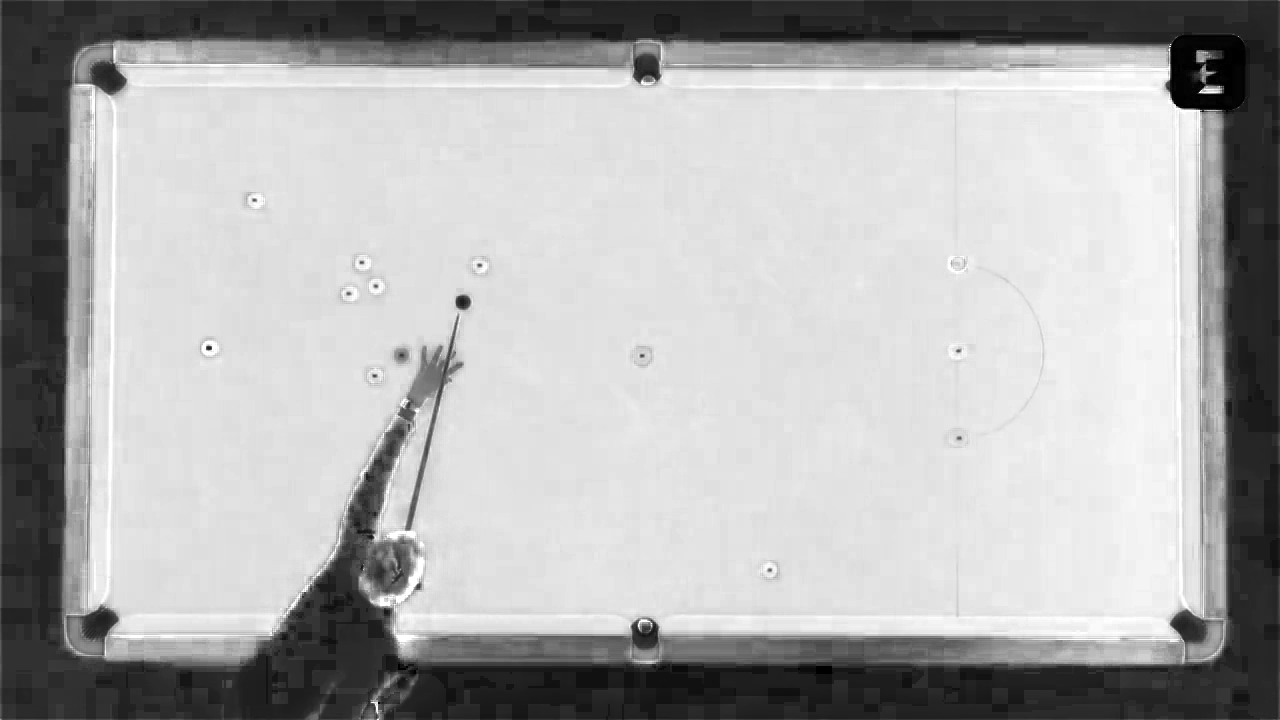

In [45]:
show_image(cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)[:,:,1])

In [54]:
def threshold(image, low=0, high=255):
    val_1 = cv2.threshold(image, low, 255, cv2.THRESH_BINARY)[1]
    val_2 = cv2.threshold(image, high, 255, cv2.THRESH_BINARY_INV)[1]
    return cv2.bitwise_and(val_1,val_2)
def ball_separator(image, color):
    match color.lower():
        case "red":
            sep_1 = cv2.threshold(image[:,:,1], 70, 255, cv2.THRESH_BINARY_INV)[1]
            sep_2 = cv2.threshold(image[:,:,2], 80, 255, cv2.THRESH_BINARY)[1]
            return cv2.bitwise_and(sep_1,sep_2)
        case "pink":
            sep_1 = cv2.threshold(image[:,:,0], 60, 255, cv2.THRESH_BINARY)[1]
            sep_2 = cv2.threshold(image[:,:,2], 220, 255, cv2.THRESH_BINARY)[1]
            sep_3 = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 180, 255, cv2.THRESH_BINARY)[1]
            return cv2.morphologyEx(cv2.bitwise_and(sep_1,sep_2)- sep_3, cv2.MORPH_OPEN, kernel=np.ones((3,3)))
        case "blue":
            sep_1 = cv2.threshold(image[:,:,0], 90, 255, cv2.THRESH_BINARY)[1]
            sep_2 = cv2.threshold(image[:,:,2], 23, 255, cv2.THRESH_BINARY_INV)[1]
            return cv2.bitwise_and(sep_1,sep_2)
        case "black":
            sep_1 = cv2.threshold(image[:,:,1], 80, 255, cv2.THRESH_BINARY_INV)[1]
            sep_2 = cv2.threshold(image[:,:,2], 15, 255, cv2.THRESH_BINARY_INV)[1]
            return cv2.bitwise_and(sep_1,sep_2)
        case "green": # tego sie nie da
            sep_1 = cv2.threshold(image[:,:,0], 40, 255, cv2.THRESH_BINARY)[1]
            sep_2 = threshold(image[:,:,1], 110, 158)
            sep = cv2.bitwise_and(sep_1,sep_2)
            return cv2.dilate(cv2.morphologyEx(np.clip(sep.astype(int) - ball_separator(image, "pink").astype(int) - ball_separator(image, "blue").astype(int), 0, 255).astype(np.uint8), cv2.MORPH_OPEN, kernel=np.ones((3,3))), kernel=np.ones((3,3)))
        case "yellow":
            sep_2 = threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 150, 200)
            sep_1 = cv2.threshold(image[:,:,0], 80, 255, cv2.THRESH_BINARY)[1]
            return np.clip(sep_2.astype(int) - sep_1.astype(int), 0, 255).astype(np.uint8)
        case "white":    
            sep_1 = cv2.threshold(image[:,:,2], 230, 255, cv2.THRESH_BINARY)[1]
            sep_2 = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 210, 255, cv2.THRESH_BINARY)[1]
            sep_3 =  cv2.threshold(image[:,:,1], 254, 255, cv2.THRESH_BINARY)[1]
            return cv2.bitwise_and(cv2.bitwise_and(sep_3,sep_1),sep_2)
        case "brown":
            sep_1 = threshold(image[:,:,2], 60, 250)
            sep_2 = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 100, 255, cv2.THRESH_BINARY_INV)[1]
            sep_3 = threshold(image[:,:,1], 65, 160)
            return cv2.morphologyEx(cv2.bitwise_and(cv2.bitwise_and(sep_1,sep_2), sep_3), cv2.MORPH_OPEN, kernel=np.ones((3,3)))
        case _:
            raise ValueError

In [34]:
circles = cv2.HoughCircles(frame, cv2.HOUGH_GRADIENT, 1, 1, param1=200, param2=15, minRadius=1, maxRadius=20)
circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    cv2.circle(frame,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(frame,(i[0],i[1]),2,(0,0,255),3)
show_image(frame)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/hough.cpp:2283: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'HoughCircles'


In [10]:
def threshold(image, low=0, high=255):
    sep_1 = cv2.threshold(image, low, 255, cv2.THRESH_BINARY)[1]
    sep_2 = cv2.threshold(image, high, 255, cv2.THRESH_BINARY_INV)[1]
    return cv2.bitwise_and(sep_1,sep_2)

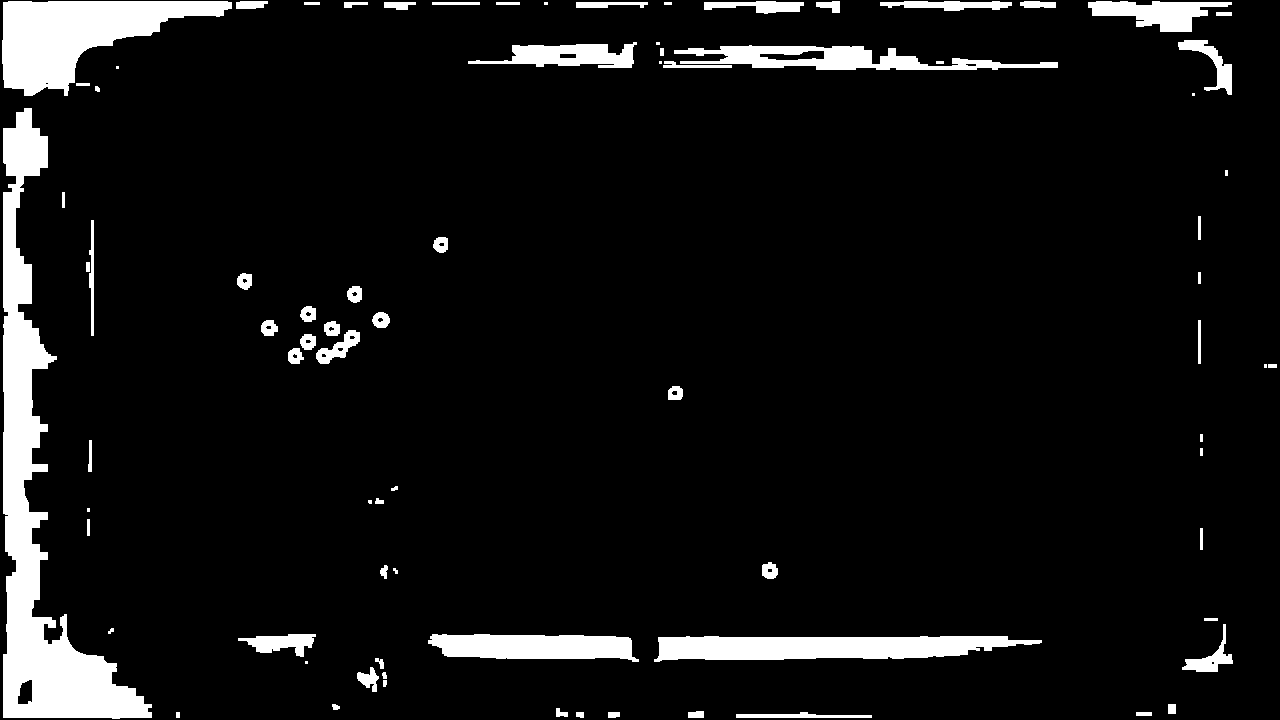

In [97]:

sep_1 = threshold(frame[:,:,2], 60, 250)
sep_2 = cv2.threshold(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY), 100, 255, cv2.THRESH_BINARY_INV)[1]
sep_3 = threshold(frame[:,:,1], 0, 170)
show_image(cv2.morphologyEx(cv2.bitwise_and(cv2.bitwise_and(sep_1,sep_2), sep_3), cv2.MORPH_OPEN, kernel=np.ones((3,3))))



In [ ]:
np.unique(ball_separator(frame,"red")//255)

array([0, 1], dtype=uint8)

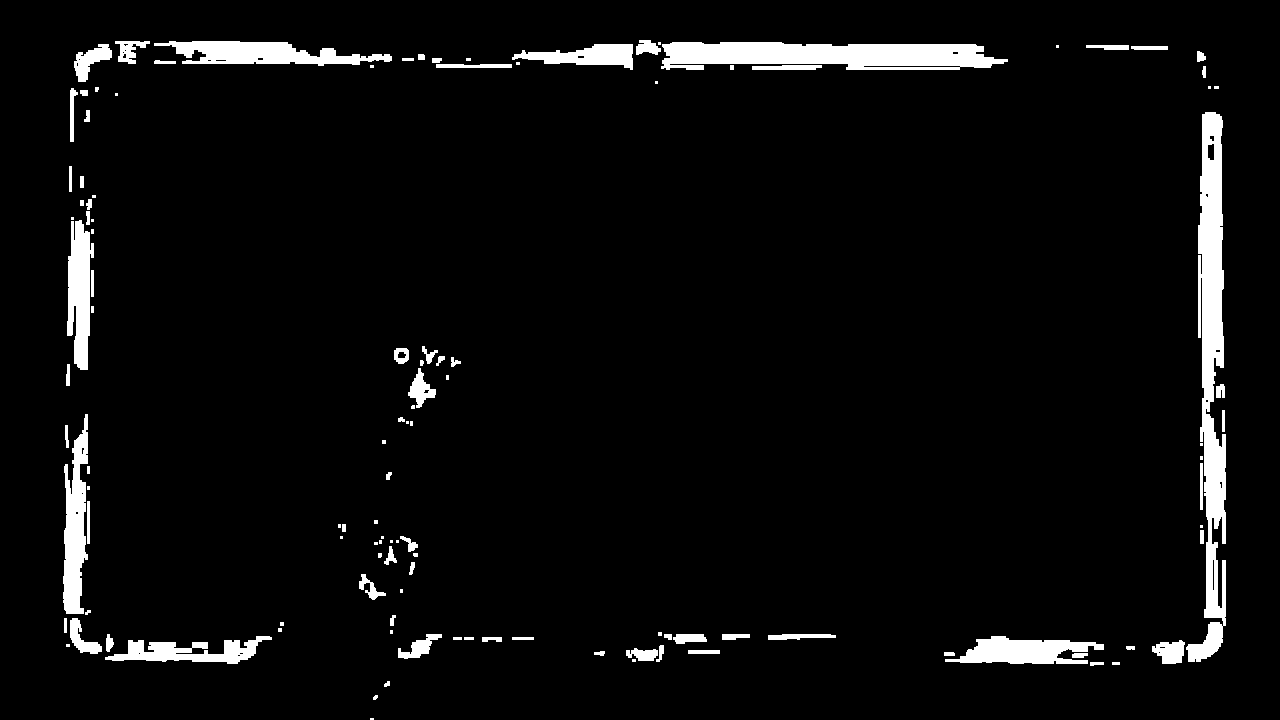

In [46]:
sep_3 = threshold(cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)[:,:,1], 120, 180)
show_image(cv2.morphologyEx(sep_3, cv2.MORPH_OPEN, kernel=np.ones((3,3))))

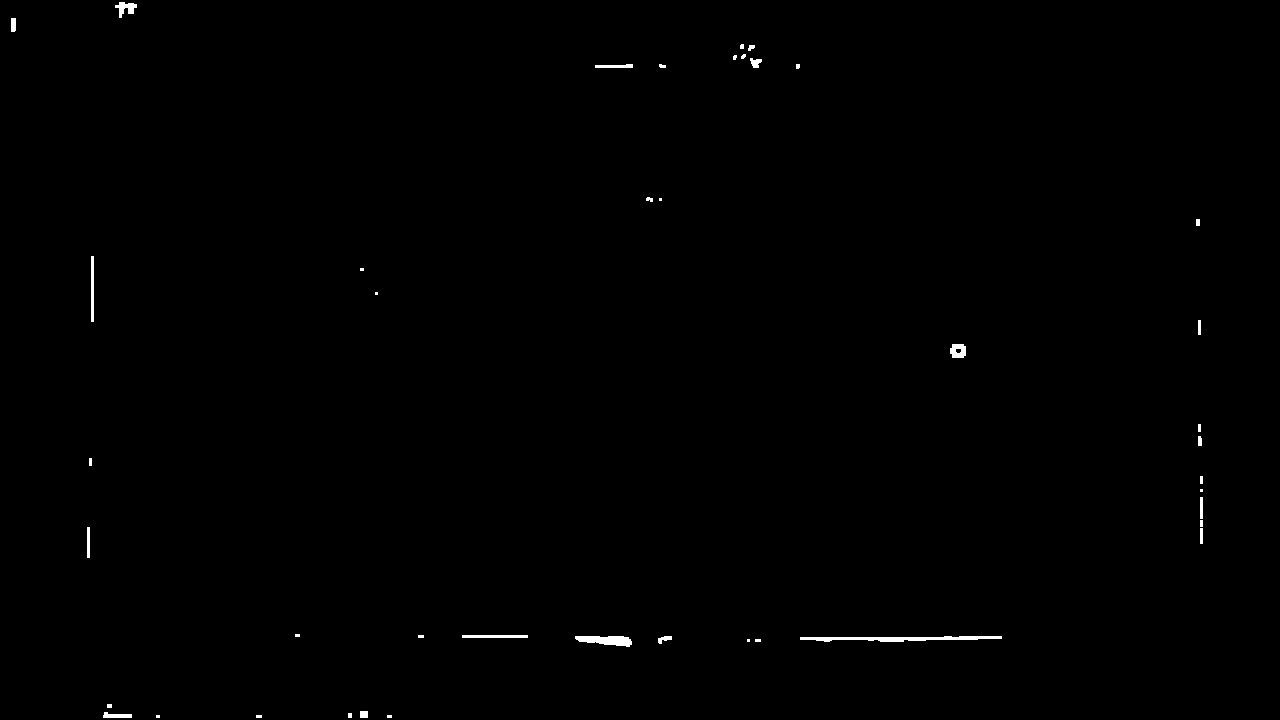

In [55]:
show_image(ball_separator(frame, "brown"))

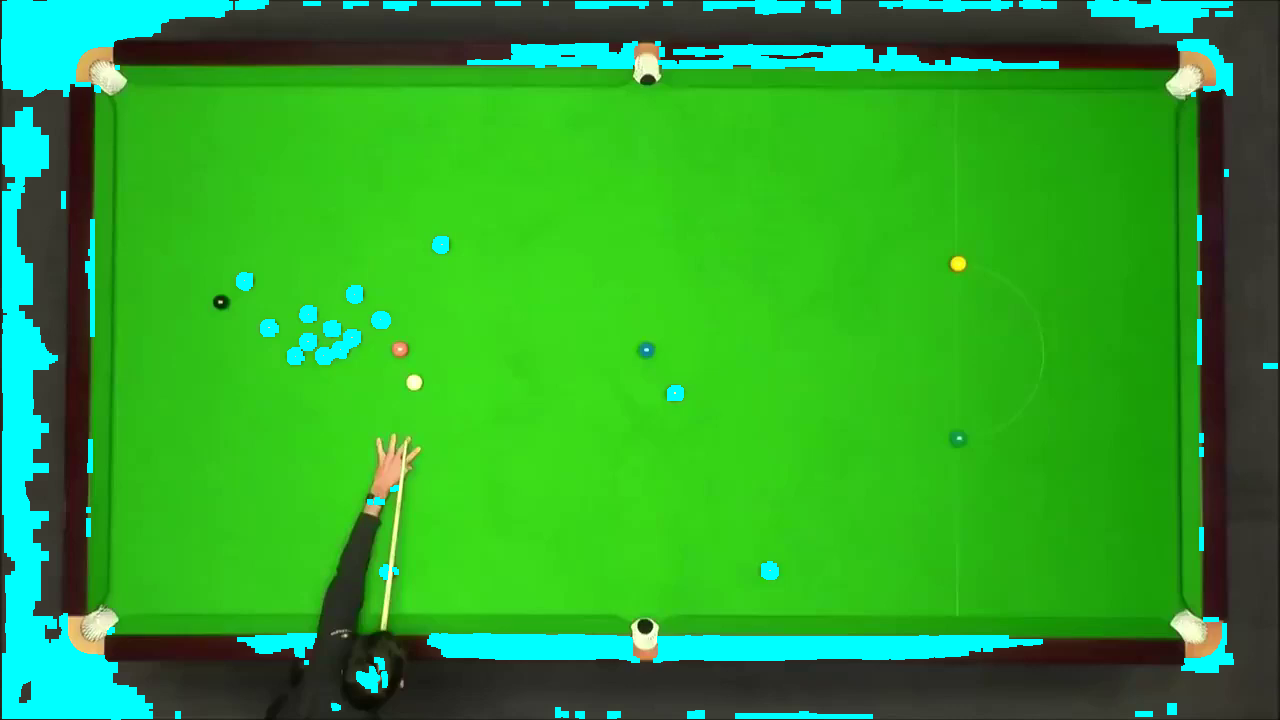

In [ ]:
frame[cv2.dilate(cv2.morphologyEx((ball_separator(frame,"brown").reshape(720,1280,1)), cv2.MORPH_OPEN, kernel=np.ones((3,3))), kernel=np.ones((3,3)))==255] = [255,255,0]
show_image(frame)

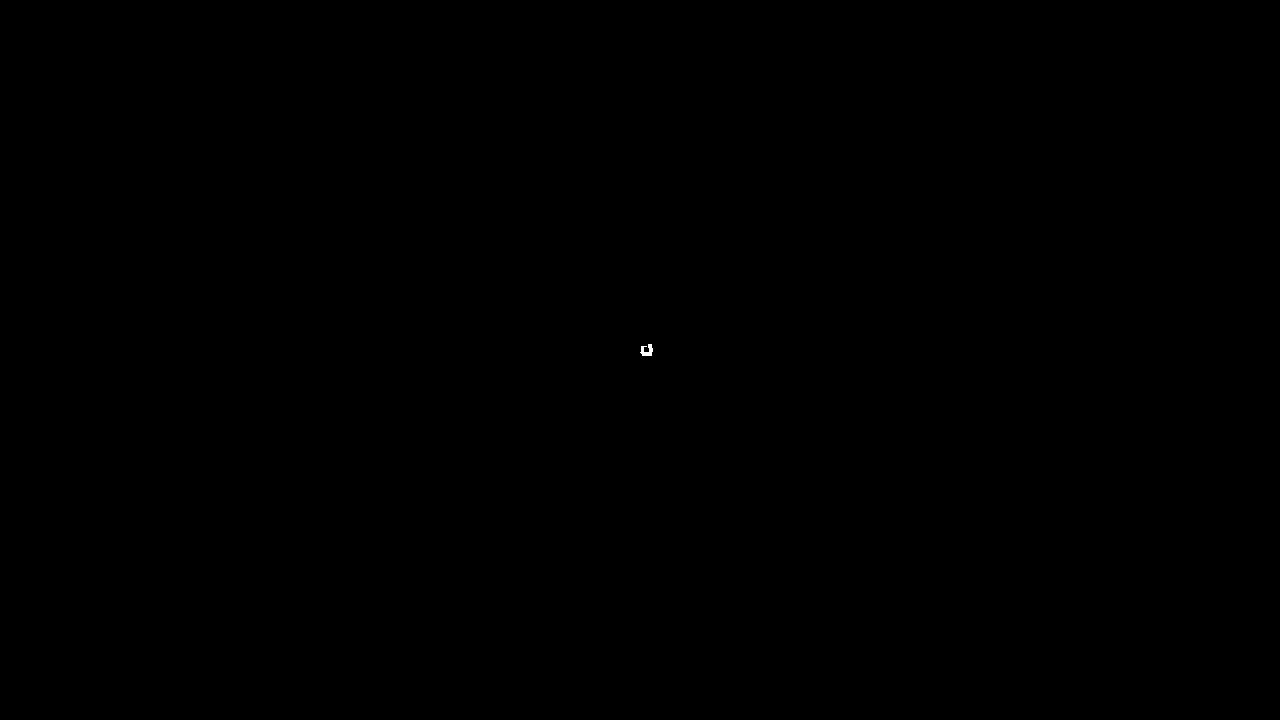

In [ ]:
sep_1 = cv2.threshold(frame[:,:,0], 90, 255, cv2.THRESH_BINARY)[1]
sep_2 = cv2.threshold(frame[:,:,2], 23, 255, cv2.THRESH_BINARY_INV)[1]
show_image(cv2.bitwise_and(sep_1,sep_2))

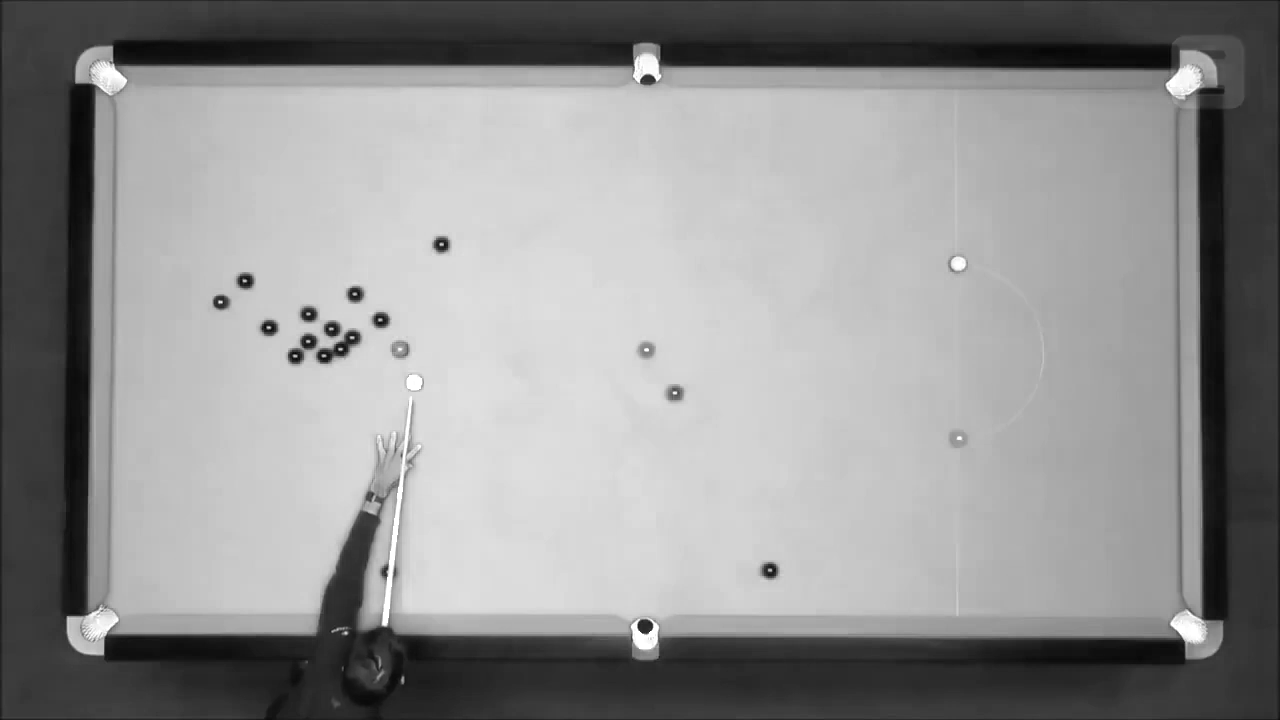

In [ ]:
show_image(frame[:,:,1])